In [1]:
import numpy as np
import imageio

In [2]:
# 
class VOC2012:
    """ handle VOC 2012 segmentation dataset
    
    """
    
    # colour map
    label_colours = [(0,0,0)
                # 0=background
                ,(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128)
                # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                ,(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0)
                # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                ,(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128)
                # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                ,(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
                # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

    # generate image record list
    def read_labeled_image_list(self, data_dir, data_list):
        """Reads txt file containing paths to images and ground truth masks.

        Args:
          data_dir: path to the directory with images and masks.
          data_list: path to the file with lines of the form '/path/to/image /path/to/mask'.

        Returns:
          list of dictionaries with file names for images and masks, respectively.
          sample record: {'image': f, 'annotation': annotation_file, 'filename': filename}
        """
        records_list = []
        with open(data_list, 'r') as f:

            for line in f:
                try:
                    image, mask = line.strip("\n").split(' ')
                except ValueError: # Adhoc for test.
                    image = mask = line.strip("\n")
                    print('WARNING:----image file: {}, -----mask file: {}'.format(image, mask))

                # full paths
                image_file = data_dir + image
                mask_file  = data_dir + mask
                
                # get the file name without the suffix (.jpeg, .png)
                filename = image.split('/')[-1].split('.')[0]
                # print(filename)
                
                records_list.append({'image':image_file, 'annotation':mask_file, 'filename': filename})

        return records_list
        
    # load an image and a mask
    def read_images_from_disk(self, input_img, input_mask, rgb_2_bgr=False): 
        """Read one image and its corresponding mask.

        Args:
          input_img:  path to the image.
          imput_mask: path to the mask

        Returns:
          Two tensors: the decoded image and its mask.
        """

        # 1. image
        img = imageio.imread(input_img)

        # 2. label
        label = imageio.imread(input_mask)

        return img, label
    

    def decode_labels(self, mask, num_classes=21):
        """Decode batch of segmentation masks.

        Args:
          mask: result of inference after taking argmax.
          num_images: number of images to decode from the batch.
          num_classes: number of classes to predict (including background).

        Returns:
          A batch with num_images RGB images of the same size as the input. 
        """
        h, w = mask.shape
        outputs = np.zeros((h, w, 3), dtype=np.uint8)
        """
        img = Image.new('RGB', (w, h)) # Size is given as a (width, height)-tuple.
        pixels = img.load()
        for j_, j in enumerate(mask[:, :]):
            for k_, k in enumerate(j):
                if k < num_classes:
                    pixels[k_,j_] = label_colours[k]
        outputs = np.array(img)
        """
        for hh in range(h):
            for ww in range(w):
                k = mask[hh, ww]
                if k<num_classes:
                    outputs[hh, ww] = VOC2012.label_colours[k]

        return outputs

In [3]:
"""
Code ideas from https://github.com/Newmu/dcgan and tensorflow mnist dataset reader
"""

class BatchDatset:
    files = []
    images = []
    annotations = []
    image_options = {}
    batch_offset = 0
    epochs_completed = 0

    def __init__(self, records_list, image_options={}):
        """
        Intialize a generic file reader with batching for list of files
        :param records_list: list of file records to read -
        sample record: {'image': f, 'annotation': annotation_file, 'filename': filename}
        :param image_options: A dictionary of options for modifying the output image
        Available options:
        resize = True/ False
        resize_size = #size of output image - does bilinear resize
        color=True/False
        """
        print("Initializing Batch Dataset Reader...")
        print(image_options)
        self.files = records_list
        self.image_options = image_options
        self._read_images()

    def _read_images(self):
        self.__channels = True
        self.images = np.array([self._transform(filename['image']) for filename in self.files])
        self.__channels = False
        self.annotations = np.array(
            [np.expand_dims(self._transform(filename['annotation']), axis=3) for filename in self.files])
        print (self.images.shape)
        print (self.annotations.shape)

    def _transform(self, filename):
        """ load a file and make some changes
            Args:
              filename: image file name
            Return:
              ndarray for the given image
        """
        # load an image
        image = imageio.imread(filename)
        
        if self.__channels and len(image.shape) < 3:  # make sure images are of shape(h,w,3)
            image = np.array([image for i in range(3)])
            
        # check resize option
        if self.image_options.get("resize", False) and self.image_options["resize"]:
            resize_size = int(self.image_options["resize_size"])
            resize_image = imageio.imresize(image,
                                         [resize_size, resize_size], interp='nearest')
        else:
            resize_image = image

        return resize_image # np.array(resize_image)
    
    def image_scaling(self, img, label):
        """
        Randomly scales the images between 0.5 to 1.5 times the original size.

        Args:
          img: Training image to scale.
          label: Segmentation mask to scale.
        """
        # img sizes
        h = img.shape[0]   # height
        w = img.shape[1]   # width
        
        # scale
        scale = np.random.uniform(low=0.5, high=1.5)

        # scale
        h_new = int(h*scale)
        w_new = int(w*scale)
        #
        new_shape = [h_new, w_new]
        #
        img   = imageio.imresize(img, new_shape, interp='nearest')
        label = imageio.imresize((label, new_shape, interp='nearest')

        return img, label

    def image_mirroring(self, img, label):
        """
        Randomly mirrors the images.

        Args:
          img: Training image to mirror. [h, w, c]
          label: Segmentation mask to mirror.
        """
        # probability
        distort_left_right_random = np.random.uniform(low=0, high=1.0)
        #
        if distort_left_right_random < 0.5:
            np.fliplr(img[:, ::-1, :])
            np.fliplr(label[:, ::-1, :])

        return img, label
                                 
    def pad_image(self, img, target_size):
        """Pad an image up to the target size.
        Args:
          img: 3d image array (h, w, c)
          target_size: 2d target size (H, W)
        Returns:
          padded image, 3d
        """
        rows_missing = target_size[0] - img.shape[0]
        cols_missing = target_size[1] - img.shape[1]
        #
        padded_img = np.pad(img, ((0, rows_missing), (0, cols_missing), (0, 0)), 'constant')
        return padded_img

    def random_crop(self, img, target_size):
        """crop an image up to the target size.
        Args:
          img: 3d image array (h, w, c)
          target_size: 2d target size (H, W)
        Returns:
          cropped image, 3d
        """
        h, w, c = img.shape
                                 
        # offset from [0, low)
        offset = np.random.randint(low=5)

        return img[offset:target_size[0]+offset, offset:target_size[1]+offset, :]

    def random_crop_and_pad_image_and_labels(self, image, label, crop_size, ignore_label=255):
        """ Randomly crop and pads the input images.
        
        slice a shape 'crop_size' portion out of the input at a uniformly chosen offset.
        Requires 'image.shape >= size'

        Args:
          image: Training image to crop/ pad. dimension (h, w, c)
          label: Segmentation mask to crop/ pad. dimension (h, w, 1)
          crop_size: [crop_h, crop_w], (Height of cropped segment, Width of cropped segment)
          ignore_label: Label to ignore during the training.
          
        Returns:
          A cropped array
        """
        #
        h, w, c = image.shape
        crop_h, crop_w = crop_size
                                 
        #
        label = np.asarray(label, dtype=np.float32)
        label = label - ignore_label # Needs to be subtracted and later added due to 0 padding.
                                 
        combined = np.concat(axis=2, values=[image, label]) 

        combined_pad = self.pad_image(combined, (max(crop_h, h), max(crop_w, w)) )

        last_image_dim = c
        # last_label_dim = tf.shape(label)[-1]
        combined_crop = self.random_crop(combined_pad, [crop_h, crop_w, 4])
        img_crop = combined_crop[:, :, :last_image_dim]
        label_crop = combined_crop[:, :, last_image_dim:]
                                 
        label_crop = label_crop + ignore_label
        label_crop = label_crop.astype(dtype=np.uint8)

        # Set static shape so that tensorflow knows shape at compile time. 
        img_crop.set_shape((crop_h, crop_w, 3))
        label_crop.set_shape((crop_h,crop_w, 1))
                                 
        return img_crop, label_crop  


    def get_records(self):
        return self.images, self.annotations

    def reset_batch_offset(self, offset=0):
        self.batch_offset = offset

    def next_batch(self, batch_size):
        start = self.batch_offset
        self.batch_offset += batch_size
        if self.batch_offset > self.images.shape[0]:
            # Finished epoch
            self.epochs_completed += 1
            print("****************** Epochs completed: " + str(self.epochs_completed) + "******************")
            # Shuffle the data
            perm = np.arange(self.images.shape[0])
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.annotations = self.annotations[perm]
            # Start next epoch
            start = 0
            self.batch_offset = batch_size

        end = self.batch_offset
        return self.images[start:end], self.annotations[start:end]

    def get_random_batch(self, batch_size):
        indexes = np.random.randint(0, self.images.shape[0], size=[batch_size]).tolist()
        return self.images[indexes], self.annotations[indexes]


In [4]:
data_dir = "./VOC2012"
data_list="./dataset/train.txt"

#
voc12 = VOC2012()

# load file names
image_record = voc12.read_labeled_image_list(data_dir, data_list)
#
print(image_record[0]['image'], image_record[0]['annotation'])

# load image and mask
import os
#
ii = 15
for i in range(ii, len(image_record)):
    image = image_record[i]['image']
    mask  = image_record[i]['annotation']
    if os.path.exists(image) and os.path.exists(mask):
        img,label = voc12.read_images_from_disk(image, mask)
        print(img.shape, label.shape)
        break

./VOC2012/JPEGImages/2007_000032.jpg ./VOC2012/SegmentationClassAug/2007_000032.png
(412, 500, 3) (412, 500)


In [5]:
print(img.dtype, img.shape, label.dtype, label.shape)

uint8 (412, 500, 3) uint8 (412, 500)


In [6]:
# load a batch of data
bd = BatchDatset(image_record[:500])
#
batch_size = 10
images, masks = bd.next_batch(batch_size)

Initializing Batch Dataset Reader...
{}
... filename: ./VOC2012/JPEGImages/2007_000032.jpg, shape: (281, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000039.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000063.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000068.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000121.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000170.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000241.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000243.jpg, shape: (333, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000250.jpg, shape: (375, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000256.jpg, shape: (343, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000333.jpg, shape: (333, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000363.jpg, shape: (333, 500, 3)
... filename: ./VOC2012/JPEGImages/2007_000364.jpg, shape: (375, 500, 3)
... filenam

/home/hzh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


... filename: ./VOC2012/SegmentationClassAug/2007_004768.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004769.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004810.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004830.png, shape: (333, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004841.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004948.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004951.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004988.png, shape: (342, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_004998.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_005043.png, shape: (254, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_005064.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClassAug/2007_005086.png, shape: (375, 500)
... filename: ./VOC2012/SegmentationClas

In [11]:
print(images[0].shape, masks[0].shape)

(281, 500, 3) (281, 500, 1)


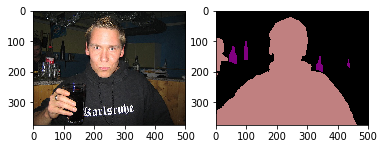

In [14]:
# plotting
%matplotlib inline
import matplotlib.pyplot as plt

#
fig, axes = plt.subplots(nrows=1, ncols=2)

#
i = 5

# image
axes[0].imshow(images[i])

# label
label0 = voc12.decode_labels(np.squeeze(masks[i]))
axes[1].imshow(label0)

In [18]:
aa=np.array([[1], [2], [3]])
print(aa)
aa.reshape(-1)

[[1]
 [2]
 [3]]


array([1, 2, 3])